In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
from pathlib import Path

os.chdir("..")

# METLOOM

In [20]:
from omegaconf import OmegaConf
from multiearth.api import extract_assets
from multiearth.config import ConfigSchema

cfg = OmegaConf.load("config/metloom.yaml")
cfg_schema = OmegaConf.structured(ConfigSchema)
cfg = OmegaConf.merge(cfg_schema, cfg)

print(OmegaConf.to_yaml(cfg))

# Constrain the test to only pull one item
for pvdr in cfg.providers:
    for coll in pvdr.collections:
        coll.max_items = 1
cfg.system.dry_run = False

success = extract_assets(cfg)
print("Successfully extracted assets." if success else "Asset extraction failed.")

02:43:07 INFO - Extraction details for provider ProviderKey.METLOOM with collection SNOTEL: 
id: CDEC
assets:
- SWE
outdir: data/cdec_conus_expanded
datetime: 2017-04-01/2021-04-23
aoi_file: config/aoi/conus-expanded.json
max_items: 1

02:43:07 INFO - Extraction details for provider ProviderKey.METLOOM with collection CDEC: 
id: CDEC
assets:
- SWE
outdir: data/cdec_conus_expanded
datetime: 2017-04-01/2021-04-23
aoi_file: config/aoi/conus-expanded.json
max_items: 1

02:43:07 INFO - Extracting assets '[SensorDescription(code='WTEQ', name='SWE', description=None, accumulated=False), SensorDescription(code='TOBS', name='AIR TEMP', description=None, accumulated=False)]' for SNOTEL


default_collection:
  id: null
  assets: null
  outdir: null
  datetime: null
  aoi_file: null
  max_items: -1
providers:
- id: METLOOM
  kwargs: {}
  collections:
  - id: SNOTEL
    assets:
    - SWE
    - AIR TEMP
    outdir: data/snotel_land_cover_north_america
    datetime: 2017-04-01/2021-04-23
    aoi_file: config/aoi/demo_landcover.json
    max_items: 3
  - id: CDEC
    assets:
    - SWE
    outdir: data/cdec_conus_expanded
    datetime: 2017-04-01/2021-04-23
    aoi_file: config/aoi/conus-expanded.json
    max_items: 3
system:
  log_outdir: ./logs
  log_level: INFO
  dry_run: false
  max_concurrent_extractions: 10
  max_download_attempts: 3
  remove_existing_if_wrong_size: true
  query_asset_sizes: false
run_id: ''



100%|██████████| 8/8 [00:02<00:00,  3.33it/s]
02:43:11 INFO - Region to items took 0.0674 minutes
100%|██████████| 1/1 [00:04<00:00,  4.05s/it]
02:43:15 INFO - Downloading data took 0.1351 minutes
02:43:15 INFO - Extracting assets '[SensorDescription(code='3', name='SWE', description='SNOW, WATER CONTENT', accumulated=False)]' for CDEC
02:43:16 INFO - Region to items took 0.0185 minutes
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
02:43:17 INFO - Downloading data took 0.0281 minutes


Successfully extracted assets.


We"ve extracted assets from a single station in this notebook. Note that max_items refers to the maximum number of stations queried.

In [21]:
fpath = str(Path(cfg["providers"][0]["collections"][0]["outdir"]))
files = list(glob.glob(fpath + "/*csv"))

# We know there is only one provider pulled, assert
assert (
    len(files) == 1
), f"There were {len(files)} files pulled. `max_items: 1` failed to constrain."

file_path = files[0]
df = pd.read_csv(file_path)
time_var = "datetime"
df[time_var] = pd.to_datetime(df[time_var]).copy()

# We know there is only one station pulled, assert
assert (
    len(df.groupby("geometry", as_index=False)) == 1
), f"There were {len(df.groupby('geometry', as_index=False))} station records pulled. `max_items: 1` failed to constrain."

In [22]:
df.head()

,datetime,site,geometry,SWE,SWE_units,AIR TEMP,AIR TEMP_units,datasource
0,2017-04-01 08:00:00+00:00,340:NV:SNTL,POINT Z (-119.9422 39.455 8235),50.7,in,29.66,degF,NRCS
1,2017-04-02 08:00:00+00:00,340:NV:SNTL,POINT Z (-119.9422 39.455 8235),50.6,in,35.24,degF,NRCS
2,2017-04-03 08:00:00+00:00,340:NV:SNTL,POINT Z (-119.9422 39.455 8235),50.6,in,29.84,degF,NRCS
3,2017-04-04 08:00:00+00:00,340:NV:SNTL,POINT Z (-119.9422 39.455 8235),50.4,in,27.86,degF,NRCS
4,2017-04-05 08:00:00+00:00,340:NV:SNTL,POINT Z (-119.9422 39.455 8235),50.0,in,35.42,degF,NRCS


Let"s select a time window across January 2020 to plot the SWE and Air Temperature across.

In [23]:
start_date = "2020-01-01"
end_date = "2020-01-31"
window_df = df[(df[time_var] > start_date) & (df[time_var] < end_date)].copy()
window_df.loc[:, time_var] = window_df.loc[:, time_var].dt.date
window_df.head()

,datetime,site,geometry,SWE,SWE_units,AIR TEMP,AIR TEMP_units,datasource
1005,2020-01-01,340:NV:SNTL,POINT Z (-119.9422 39.455 8235),9.1,in,36.14,degF,NRCS
1006,2020-01-02,340:NV:SNTL,POINT Z (-119.9422 39.455 8235),9.1,in,28.04,degF,NRCS
1007,2020-01-03,340:NV:SNTL,POINT Z (-119.9422 39.455 8235),9.1,in,34.52,degF,NRCS
1008,2020-01-04,340:NV:SNTL,POINT Z (-119.9422 39.455 8235),9.1,in,36.32,degF,NRCS
1009,2020-01-05,340:NV:SNTL,POINT Z (-119.9422 39.455 8235),9.1,in,31.28,degF,NRCS


Text(0.5, 0.98, 'SWE and Air Temp from 2020-01-01 to 2020-01-31')

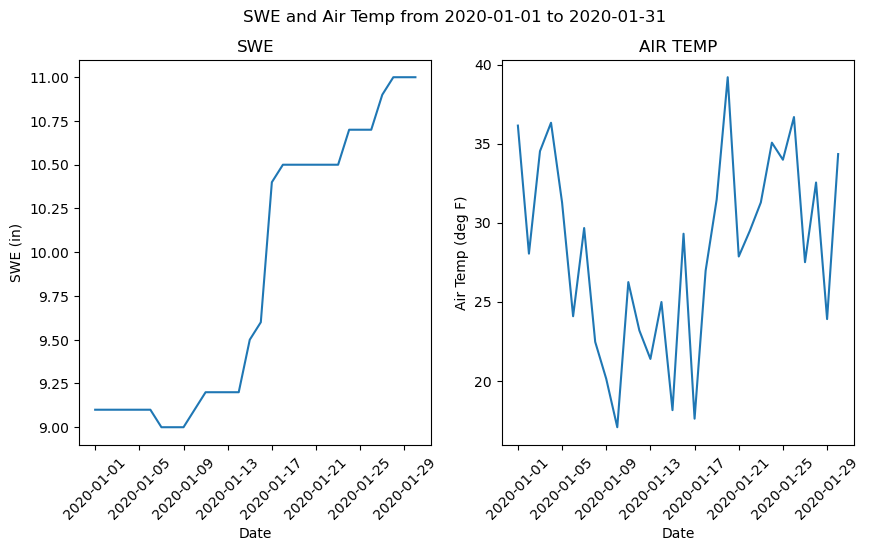

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
window_df.plot(
    ax=ax,
    y="SWE",
    x=time_var,
    ylabel="SWE (in)",
    xlabel="Date",
    rot=45,
    legend=None,
    title="SWE",
)


ax = axes[1]
window_df.plot(
    ax=ax,
    y="AIR TEMP",
    x=time_var,
    ylabel="Air Temp (deg F)",
    xlabel="Date",
    rot=45,
    legend=None,
    title="AIR TEMP",
)

fig.suptitle(f"SWE and Air Temp from {start_date} to {end_date}")